# Urban Bike

- Predict available bicycle capacity over the next 30-90 minutes so this data can be made available to customers on the app.

- Key part of this is to predict the duration of the bike trips (time picked up to time returned)

- We have 3 datasets to help with this task
    1. bike docking stations
    2. Historical trips
    3. Weather

## Approach

**Step 1: Prepare the dataset**

    Use the three datasets and use a series of joins to make one dataset which gives all relevant information on  historical trips, along with information on the docking station the bike is collected from and the weather.

    Make use of feature engineering to create any additional features that may be useful in order to gain better understanding and make more sense within the context of the problem.


**Step 2: Exploratory Data Analysis**

    Look into the data and see if there are any data quality issues that need to be addressed or combated, look into the distribution of the data and it's correlation with the target variable

**Step 3: Prepare the Dataset for Training**

    Prepare the dataset to be passed into a model for training, splitting into a training and test set, one-hot-encoding any columns that may require, and drop any columns that are too highly correlated.

**Step 4: Train and Evaluate an ML Model**

    Fit the data into a sklearn regression model (as this is a regression problem).

    Evaluate the results using metrics (e.g. MSE and R2) - testing both the training and test set to check for overfitting.

    Look into improvements on the model:
    - cross validation for overfitting
    - hyper-parameter tuning
    - testing out different models (e.g. SVM or Random Forrest Regressor)

### Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

## Step 1: Prepare the Dataset

Loading in the dataset as dataframes

In [2]:
stations_df = pd.read_csv('data/hubway_stations.csv')
stations_df

,id,terminal,station,municipal,lat,lng,status
0,3,B32006,Colleges of the Fenway,Boston,42.340021,-71.100812,Existing
1,4,C32000,Tremont St. at Berkeley St.,Boston,42.345392,-71.069616,Existing
2,5,B32012,Northeastern U / North Parking Lot,Boston,42.341814,-71.090179,Existing
3,6,D32000,Cambridge St. at Joy St.,Boston,42.361285,-71.065140,Existing
4,7,A32000,Fan Pier,Boston,42.353412,-71.044624,Existing
...,...,...,...,...,...,...,...
137,141,S32008,Powder House Circle,Somerville,42.400877,-71.116772,Existing
138,142,S32009,Packard Ave / Powderhouse Blvd,Somerville,42.404490,-71.123413,Existing
139,143,S32010,Somerville Hospital at Highland Ave / Crocker St,Somerville,42.390820,-71.109420,Existing
140,144,S32011,Teele Square at 239 Holland St,Somerville,42.402763,-71.126908,Existing


In [3]:
trips_df = pd.read_csv('data/hubway_trips.csv')
trips_df

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
0,1,8,Closed,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male
1,2,9,Closed,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male
2,3,10,Closed,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male
3,4,11,Closed,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female
4,5,12,Closed,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,Closed,720,11/30/2013 23:30:00,130.0,11/30/2013 23:42:00,90.0,T01341,Registered,'02141,NaN,Male
1579021,1579022,1748019,Closed,480,11/30/2013 23:32:00,67.0,11/30/2013 23:40:00,88.0,T01328,Registered,'02143,NaN,Male
1579022,1579023,1748020,Closed,540,11/30/2013 23:32:00,137.0,11/30/2013 23:41:00,133.0,T01310,Casual,NaN,NaN,NaN
1579023,1579024,1748021,Closed,120,11/30/2013 23:36:00,76.0,11/30/2013 23:38:00,68.0,B01478,Registered,'02141,NaN,Male


In [4]:
weather_df = pd.read_csv('data/weather.csv')
weather_df

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
0,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 09:00,0.00,T,
1,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 10:00,0.00,T,
2,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 18:00,0.00,T,
3,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 21:00,0.03,,
4,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110729 22:00,0.04,,
...,...,...,...,...,...,...,...,...,...
2649,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 15:00,0.03,,
2650,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 16:00,0.35,,
2651,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 17:00,0.19,,
2652,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130723 18:00,0.00,T,


### Merging the Datasets into trips_df

I now want to combine the datasets so that we have one dataset which can be used for the trips, so I will add the weather and station data onto the trips dataset for each instance of trip

In [5]:
# Joining trips and stations on "id" and "strt_statn"
trips_df = trips_df.drop(columns=["status"])
trips_df = trips_df.merge(stations_df, left_on="strt_statn", right_on="id", how="left")
trips_df

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,id,terminal,station,municipal,lat,lng,status
0,1,8,9,7/28/2011 10:12:00,23.0,7/28/2011 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
1,2,9,220,7/28/2011 10:21:00,23.0,7/28/2011 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
2,3,10,56,7/28/2011 10:33:00,23.0,7/28/2011 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
3,4,11,64,7/28/2011 10:35:00,23.0,7/28/2011 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
4,5,12,12,7/28/2011 10:37:00,23.0,7/28/2011 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,720,11/30/2013 23:30:00,130.0,11/30/2013 23:42:00,90.0,T01341,Registered,'02141,NaN,Male,130.0,M32021,Harvard University Gund Hall at Quincy St / Ki...,Cambridge,42.376369,-71.114025,Existing
1579021,1579022,1748019,480,11/30/2013 23:32:00,67.0,11/30/2013 23:40:00,88.0,T01328,Registered,'02143,NaN,Male,67.0,M32006,MIT at Mass Ave / Amherst St,Cambridge,42.358100,-71.093198,Existing
1579022,1579023,1748020,540,11/30/2013 23:32:00,137.0,11/30/2013 23:41:00,133.0,T01310,Casual,NaN,NaN,NaN,137.0,M32029,Porter Square Station,Cambridge,42.387995,-71.119084,Existing
1579023,1579024,1748021,120,11/30/2013 23:36:00,76.0,11/30/2013 23:38:00,68.0,B01478,Registered,'02141,NaN,Male,76.0,M32012,Central Sq Post Office / Cambridge City Hall a...,Cambridge,42.366426,-71.105495,Existing


In [6]:
trips_df.columns

Index(['seq_id', 'hubway_id', 'duration', 'start_date', 'strt_statn',
       'end_date', 'end_statn', 'bike_nr', 'subsc_type', 'zip_code',
       'birth_date', 'gender', 'id', 'terminal', 'station', 'municipal', 'lat',
       'lng', 'status'],
      dtype='object')

In [7]:
# Dropping unneeded columns from the weather dataset
weather_df = weather_df.drop(columns=["STATION", "STATION_NAME", "LATITUDE", "LONGITUDE"])

In [8]:
weather_df.head(5)

,ELEVATION,DATE,HPCP,Measurement_Flag,Quality_Flag
0,3.7,20110729 09:00,0.00,T,
1,3.7,20110729 10:00,0.00,T,
2,3.7,20110729 18:00,0.00,T,
3,3.7,20110729 21:00,0.03,,
4,3.7,20110729 22:00,0.04,,


In [9]:
# Putting all the date/times in a standard format
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"], format="%Y%m%d %H:%M")
trips_df["start_date"] = pd.to_datetime(trips_df["start_date"], format="%m/%d/%Y %H:%M:%S")
trips_df["end_date"] = pd.to_datetime(trips_df["end_date"], format="%m/%d/%Y %H:%M:%S")

In [10]:
weather_df.head(2)

,ELEVATION,DATE,HPCP,Measurement_Flag,Quality_Flag
0,3.7,2011-07-29 09:00:00,0.0,T,
1,3.7,2011-07-29 10:00:00,0.0,T,


In [11]:
trips_df.head(2)

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,id,terminal,station,municipal,lat,lng,status
0,1,8,9,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
1,2,9,220,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed


In [12]:
trips_df = trips_df.sort_values('start_date')
trips_df

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender,id,terminal,station,municipal,lat,lng,status
0,1,8,9,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,B00468,Registered,'97217,1976.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
1,2,9,220,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,B00554,Registered,'02215,1966.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
2,3,10,56,2011-07-28 10:33:00,23.0,2011-07-28 10:34:00,23.0,B00456,Registered,'02108,1943.0,Male,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
3,4,11,64,2011-07-28 10:35:00,23.0,2011-07-28 10:36:00,23.0,B00554,Registered,'02116,1981.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
4,5,12,12,2011-07-28 10:37:00,23.0,2011-07-28 10:37:00,23.0,B00554,Registered,'97214,1983.0,Female,23.0,B32008,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,720,2013-11-30 23:30:00,130.0,2013-11-30 23:42:00,90.0,T01341,Registered,'02141,NaN,Male,130.0,M32021,Harvard University Gund Hall at Quincy St / Ki...,Cambridge,42.376369,-71.114025,Existing
1579021,1579022,1748019,480,2013-11-30 23:32:00,67.0,2013-11-30 23:40:00,88.0,T01328,Registered,'02143,NaN,Male,67.0,M32006,MIT at Mass Ave / Amherst St,Cambridge,42.358100,-71.093198,Existing
1579022,1579023,1748020,540,2013-11-30 23:32:00,137.0,2013-11-30 23:41:00,133.0,T01310,Casual,NaN,NaN,NaN,137.0,M32029,Porter Square Station,Cambridge,42.387995,-71.119084,Existing
1579023,1579024,1748021,120,2013-11-30 23:36:00,76.0,2013-11-30 23:38:00,68.0,B01478,Registered,'02141,NaN,Male,76.0,M32012,Central Sq Post Office / Cambridge City Hall a...,Cambridge,42.366426,-71.105495,Existing


In [13]:
# Merging trips_df with weather_df by matching the closest weather record, so we know the weather at the time of the trip
trips_df = pd.merge_asof(trips_df, weather_df, left_on='start_date', right_on='DATE', direction='forward')

In [14]:
trips_df

,seq_id,hubway_id,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,...,station,municipal,lat,lng,status,ELEVATION,DATE,HPCP,Measurement_Flag,Quality_Flag
0,1,8,9,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,B00468,Registered,'97217,...,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,3.7,2011-07-29 09:00:00,0.0,T,
1,2,9,220,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,B00554,Registered,'02215,...,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,3.7,2011-07-29 09:00:00,0.0,T,
2,3,10,56,2011-07-28 10:33:00,23.0,2011-07-28 10:34:00,23.0,B00456,Registered,'02108,...,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,3.7,2011-07-29 09:00:00,0.0,T,
3,4,11,64,2011-07-28 10:35:00,23.0,2011-07-28 10:36:00,23.0,B00554,Registered,'02116,...,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,3.7,2011-07-29 09:00:00,0.0,T,
4,5,12,12,2011-07-28 10:37:00,23.0,2011-07-28 10:37:00,23.0,B00554,Registered,'97214,...,Mayor Thomas M. Menino - Government Center,Boston,42.359677,-71.059364,Removed,3.7,2011-07-29 09:00:00,0.0,T,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,1579021,1748018,720,2013-11-30 23:30:00,130.0,2013-11-30 23:42:00,90.0,T01341,Registered,'02141,...,Harvard University Gund Hall at Quincy St / Ki...,Cambridge,42.376369,-71.114025,Existing,NaN,NaT,NaN,NaN,NaN
1579021,1579022,1748019,480,2013-11-30 23:32:00,67.0,2013-11-30 23:40:00,88.0,T01328,Registered,'02143,...,MIT at Mass Ave / Amherst St,Cambridge,42.358100,-71.093198,Existing,NaN,NaT,NaN,NaN,NaN
1579022,1579023,1748020,540,2013-11-30 23:32:00,137.0,2013-11-30 23:41:00,133.0,T01310,Casual,NaN,...,Porter Square Station,Cambridge,42.387995,-71.119084,Existing,NaN,NaT,NaN,NaN,NaN
1579023,1579024,1748021,120,2013-11-30 23:36:00,76.0,2013-11-30 23:38:00,68.0,B01478,Registered,'02141,...,Central Sq Post Office / Cambridge City Hall a...,Cambridge,42.366426,-71.105495,Existing,NaN,NaT,NaN,NaN,NaN


### Cleaning Data

Here I am going to check the quality of the data and clean the dataset where necessary

I will look for:
- duplicates
- missing data
- anomalies / negative values

There are further methods I could use for cleaning the data such as data imputation and using methods to check further and combat them, so this could be explored if given more time.
I could
- check for any inconsistencies with types
- check for inconsistent / incorrect time values
- etc.

At this point I am checking that the data makes sense and will remove any 'dirty' records

In [15]:
# Count of duplicate rows of data
trips_df.duplicated().sum()

0

In [16]:
# Removing any duplicates
trips_df = trips_df.drop_duplicates()

In [17]:
trips_df.isnull().sum()

seq_id                    0
hubway_id                 0
duration                  0
start_date                0
strt_statn               14
end_date                  0
end_statn                45
bike_nr                 466
subsc_type                0
zip_code             472766
birth_date          1228381
gender               472611
id                       14
terminal                 14
station                  14
municipal                14
lat                      14
lng                      14
status                   14
ELEVATION            536094
DATE                 536094
HPCP                 536094
Measurement_Flag     536094
Quality_Flag         536094
dtype: int64

In [18]:
# Dropping all rows where there is no id - as this may not be valid data
trips_df = trips_df.dropna(subset=['id'])
trips_df.isnull().sum()

seq_id                    0
hubway_id                 0
duration                  0
start_date                0
strt_statn                0
end_date                  0
end_statn                38
bike_nr                 466
subsc_type                0
zip_code             472766
birth_date          1228378
gender               472611
id                        0
terminal                  0
station                   0
municipal                 0
lat                       0
lng                       0
status                    0
ELEVATION            536094
DATE                 536094
HPCP                 536094
Measurement_Flag     536094
Quality_Flag         536094
dtype: int64

In [19]:
# Dropping all rows where there is no end station as it may mean those journeys are incomplete
trips_df = trips_df.dropna(subset=['end_statn'])
trips_df.isnull().sum()

seq_id                    0
hubway_id                 0
duration                  0
start_date                0
strt_statn                0
end_date                  0
end_statn                 0
bike_nr                 465
subsc_type                0
zip_code             472747
birth_date          1228358
gender               472592
id                        0
terminal                  0
station                   0
municipal                 0
lat                       0
lng                       0
status                    0
ELEVATION            536094
DATE                 536094
HPCP                 536094
Measurement_Flag     536094
Quality_Flag         536094
dtype: int64

### Feature Engineering

In [20]:
# Removing unnecessary columns from this now collated dataset
trips_df = trips_df.drop(columns=["seq_id", "hubway_id", "bike_nr", "zip_code", "station", "lat", "lng"])

In [21]:
trips_df.duplicated().sum()

37554

In [22]:
clean_df = trips_df.drop_duplicates()

In [23]:
trips_df

,duration,start_date,strt_statn,end_date,end_statn,subsc_type,birth_date,gender,id,terminal,municipal,status,ELEVATION,DATE,HPCP,Measurement_Flag,Quality_Flag
0,9,2011-07-28 10:12:00,23.0,2011-07-28 10:12:00,23.0,Registered,1976.0,Male,23.0,B32008,Boston,Removed,3.7,2011-07-29 09:00:00,0.0,T,
1,220,2011-07-28 10:21:00,23.0,2011-07-28 10:25:00,23.0,Registered,1966.0,Male,23.0,B32008,Boston,Removed,3.7,2011-07-29 09:00:00,0.0,T,
2,56,2011-07-28 10:33:00,23.0,2011-07-28 10:34:00,23.0,Registered,1943.0,Male,23.0,B32008,Boston,Removed,3.7,2011-07-29 09:00:00,0.0,T,
3,64,2011-07-28 10:35:00,23.0,2011-07-28 10:36:00,23.0,Registered,1981.0,Female,23.0,B32008,Boston,Removed,3.7,2011-07-29 09:00:00,0.0,T,
4,12,2011-07-28 10:37:00,23.0,2011-07-28 10:37:00,23.0,Registered,1983.0,Female,23.0,B32008,Boston,Removed,3.7,2011-07-29 09:00:00,0.0,T,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,2013-11-30 23:30:00,130.0,2013-11-30 23:42:00,90.0,Registered,NaN,Male,130.0,M32021,Cambridge,Existing,NaN,NaT,NaN,NaN,NaN
1579021,480,2013-11-30 23:32:00,67.0,2013-11-30 23:40:00,88.0,Registered,NaN,Male,67.0,M32006,Cambridge,Existing,NaN,NaT,NaN,NaN,NaN
1579022,540,2013-11-30 23:32:00,137.0,2013-11-30 23:41:00,133.0,Casual,NaN,NaN,137.0,M32029,Cambridge,Existing,NaN,NaT,NaN,NaN,NaN
1579023,120,2013-11-30 23:36:00,76.0,2013-11-30 23:38:00,68.0,Registered,NaN,Male,76.0,M32012,Cambridge,Existing,NaN,NaT,NaN,NaN,NaN


In [24]:
trips_df.columns

Index(['duration', 'start_date', 'strt_statn', 'end_date', 'end_statn',
       'subsc_type', 'birth_date', 'gender', 'id', 'terminal', 'municipal',
       'status', 'ELEVATION', 'DATE', 'HPCP', 'Measurement_Flag',
       'Quality_Flag'],
      dtype='object')

We do not need any features that are simply identification, as they may skew our model later on and we cannot perform exploratory data analysis on any of these

In [25]:
trips_df = trips_df.drop(columns=["id", "end_date", "terminal", "end_statn", "strt_statn", "status", "DATE"])

In [26]:
# Changing birth_date to age (note the documentation says this data is from 2013 so basing off age then)
trips_df['age'] = 2013 - trips_df['birth_date']
trips_df = trips_df.drop(columns=["birth_date"])

Changing the date time into two separate columns - one for month of the year, and the other for hour of the day, as these may have an effect on the duration of the journey, and put them in separate columns so that can be used for exploratory data analysis as well as passed into the ML model


In [27]:
# Changing start_date to the month and hour of the day
trips_df['month'] = trips_df['start_date'].dt.month
trips_df['hour_of_day'] = trips_df['start_date'].dt.hour
trips_df = trips_df.drop(columns=["start_date"])

In [28]:
# Removing the flag columns as have checked the data and documentation s the datasets correctly show 0 and blank where they should, and elevation is always the same
trips_df = trips_df.drop(columns=["Quality_Flag", "Measurement_Flag", "ELEVATION"])
trips_df.head(3)

,duration,subsc_type,gender,municipal,HPCP,age,month,hour_of_day
0,9,Registered,Male,Boston,0.0,37.0,7,10
1,220,Registered,Male,Boston,0.0,47.0,7,10
2,56,Registered,Male,Boston,0.0,70.0,7,10


**Remaining Features**

- duration (duration of journey - target column)
- subsc_type (the subscription type of user - Registered or Casual)
- gender (gender of user; if we have this info - Male or Female or NaN)
- municipal (municipal that the start station is located in)
- HPCP (precipitation over the last hour)
- age (age of user, if we have this info, will be some blanks)
- month (month of the year)
- hour_of_day (hour of the day of the start)

In [29]:
trips_df['HPCP'].describe

<bound method NDFrame.describe of 0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1579020    NaN
1579021    NaN
1579022    NaN
1579023    NaN
1579024    NaN
Name: HPCP, Length: 1578973, dtype: float64>

In [30]:
trips_df.isnull().sum()

duration             0
subsc_type           0
gender          472592
municipal            0
HPCP            536094
age            1228358
month                0
hour_of_day          0
dtype: int64

In [31]:
imputer = SimpleImputer(strategy='mean')

In [32]:
trips_df['age'] = imputer.fit_transform(trips_df[['age']])

In [33]:
trips_df.isnull().sum()

duration            0
subsc_type          0
gender         472592
municipal           0
HPCP           536094
age                 0
month               0
hour_of_day         0
dtype: int64

In [56]:
trip = pd.read_csv('data/hubway_trips.csv')
trip.isnull().sum()


seq_id              0
hubway_id           0
status              0
duration            0
start_date          0
strt_statn         14
end_date            0
end_statn          45
bike_nr           466
subsc_type          0
zip_code       472766
birth_date    1228381
gender         472611
dtype: int64

In [34]:
# Define conditions for categorization
conditions = [
    (trips_df['HPCP'] == 0.0),             # No rain
    (trips_df['HPCP'] > 0.0) & (trips_df['HPCP'] <= 2.5),  # Light rain
    (trips_df['HPCP'] > 2.5)               # Heavy rain
]

# Define corresponding labels
categories = ['no_rain', 'light_rain', 'heavy_rain']

trips_df['Rain_Category'] = np.select(conditions, categories, default='Unknown')

In [35]:
trips_df = trips_df.drop(columns=["gender"])

In [36]:
trips_df

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category
0,9,Registered,Boston,0.0,37.000000,7,10,no_rain
1,220,Registered,Boston,0.0,47.000000,7,10,no_rain
2,56,Registered,Boston,0.0,70.000000,7,10,no_rain
3,64,Registered,Boston,0.0,32.000000,7,10,no_rain
4,12,Registered,Boston,0.0,30.000000,7,10,no_rain
...,...,...,...,...,...,...,...,...
1579020,720,Registered,Cambridge,NaN,36.705235,11,23,Unknown
1579021,480,Registered,Cambridge,NaN,36.705235,11,23,Unknown
1579022,540,Casual,Cambridge,NaN,36.705235,11,23,Unknown
1579023,120,Registered,Cambridge,NaN,36.705235,11,23,Unknown


In [37]:
# Count occurrences of each category
rain_counts = trips_df['Rain_Category'].value_counts()

# Display the counts
print(rain_counts)

Rain_Category
no_rain       724689
Unknown       536094
light_rain    318190
Name: count, dtype: int64


## Step 2: Exploratory Data Analysis

### Further Cleaning + looking for outliers / Box Plots

In [38]:
trips_df.columns

Index(['duration', 'subsc_type', 'municipal', 'HPCP', 'age', 'month',
       'hour_of_day', 'Rain_Category'],
      dtype='object')

In [39]:
trips_df.describe()

,duration,HPCP,age,month,hour_of_day
count,1.578973e+06,1.042879e+06,1.578973e+06,1.578973e+06,1.578973e+06
mean,1.149745e+03,2.118817e-02,3.670524e+01,7.815113e+00,1.386876e+01
std,1.741980e+04,7.331841e-02,5.183353e+00,2.085583e+00,4.929931e+00
min,-6.900000e+03,0.000000e+00,1.800000e+01,3.000000e+00,0.000000e+00
25%,4.120000e+02,0.000000e+00,3.670524e+01,6.000000e+00,1.000000e+01
50%,6.600000e+02,0.000000e+00,3.670524e+01,8.000000e+00,1.500000e+01
75%,1.082000e+03,1.000000e-02,3.670524e+01,1.000000e+01,1.800000e+01
max,1.199446e+07,1.330000e+00,8.100000e+01,1.100000e+01,2.300000e+01


As can be seen, some columns are categorical at this point and some are numerical, above shows some statistics.

I have noticed here that there are some negative values for duration - which is not possible, as well as some very high values, therefore I will delete the rows of the data where the duration is invalid (another approach could be to use the absolute values as they seem to look reasonable)

In [40]:
(trips_df['duration'] < 0).sum()

49

In [41]:
trips_df[trips_df['duration'] < 0]

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category
634419,-6480,Casual,Boston,0.0,36.705235,11,1,no_rain
634420,-6480,Casual,Boston,0.0,36.705235,11,1,no_rain
634421,-5280,Registered,Boston,0.0,36.705235,11,1,no_rain
634423,-5520,Casual,Boston,0.0,36.705235,11,1,no_rain
634424,-5520,Casual,Boston,0.0,36.705235,11,1,no_rain
634425,-4740,Casual,Cambridge,0.0,36.705235,11,1,no_rain
634426,-6240,Casual,Boston,0.0,36.705235,11,1,no_rain
634427,-5460,Casual,Boston,0.0,36.705235,11,1,no_rain
634428,-5520,Casual,Boston,0.0,36.705235,11,1,no_rain
634429,-5040,Casual,Boston,0.0,36.705235,11,1,no_rain


As there are just 49 of these, I am removing them from the dataset - as mentioned before, using an absolute value is another method of doing this, fixing the data rather than removing the incorrect data. I am simply deleting it here as there are not that many records and I am taking a conservative approach, ensuring my data for training is all correct.

In [42]:
trips_df = trips_df[trips_df['duration'] >= 0]


In [43]:
trips_df

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category
0,9,Registered,Boston,0.0,37.000000,7,10,no_rain
1,220,Registered,Boston,0.0,47.000000,7,10,no_rain
2,56,Registered,Boston,0.0,70.000000,7,10,no_rain
3,64,Registered,Boston,0.0,32.000000,7,10,no_rain
4,12,Registered,Boston,0.0,30.000000,7,10,no_rain
...,...,...,...,...,...,...,...,...
1579020,720,Registered,Cambridge,NaN,36.705235,11,23,Unknown
1579021,480,Registered,Cambridge,NaN,36.705235,11,23,Unknown
1579022,540,Casual,Cambridge,NaN,36.705235,11,23,Unknown
1579023,120,Registered,Cambridge,NaN,36.705235,11,23,Unknown


In [44]:
trips_df.isnull().sum()

duration              0
subsc_type            0
municipal             0
HPCP             536063
age                   0
month                 0
hour_of_day           0
Rain_Category         0
dtype: int64

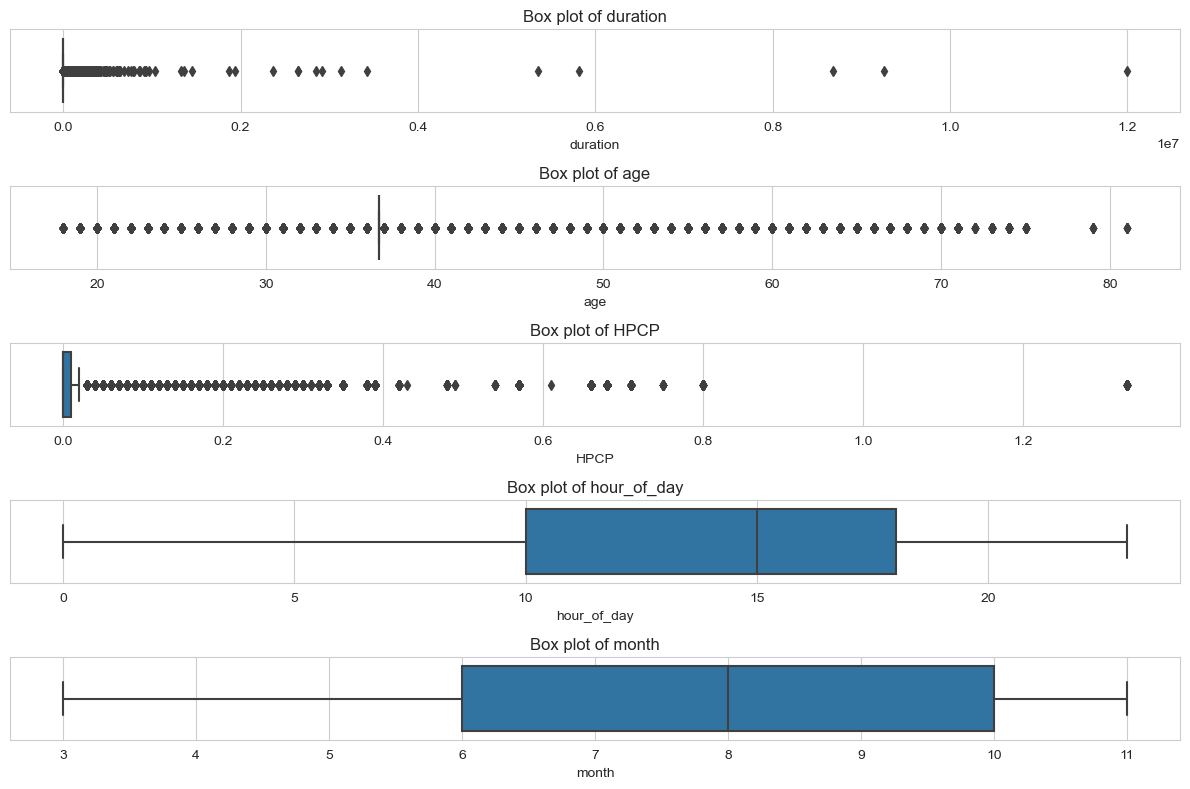

In [45]:
# Here I plot a series of box plots for all numerical columns
columns = ['duration', 'age', 'HPCP', 'hour_of_day', 'month']

plt.figure(figsize=(12, 8))

# Loop through the columns and plot box plots
for i, col in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)
    sns.boxplot(data=trips_df, x=col)
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

Here I work out Inter-Quartile-Range - which I will use to create an upper bound for outliers within my dataset

In [46]:
def detect_outliers(df, columns):
    outliers = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

In [47]:
outliers = detect_outliers(trips_df, ['duration', 'age', 'HPCP'])
outliers

{'duration': 104367, 'age': 350615, 'HPCP': 162640}

In [48]:
trips_df[trips_df['duration'] > 104367]

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category
968,230496,Casual,Boston,0.0,36.705235,7,2,no_rain
1005,105280,Casual,Boston,0.0,36.705235,7,8,no_rain
1792,133391,Casual,Boston,0.0,36.705235,7,2,no_rain
1800,303634,Casual,Boston,0.0,36.705235,7,2,no_rain
2732,146031,Casual,Boston,0.0,36.705235,7,22,no_rain
...,...,...,...,...,...,...,...,...
1453916,108600,Casual,Cambridge,NaN,36.705235,10,15,Unknown
1467861,222300,Registered,Boston,NaN,36.705235,10,15,Unknown
1497012,112500,Registered,Cambridge,NaN,36.705235,10,17,Unknown
1514177,148380,Casual,Somerville,NaN,36.705235,11,18,Unknown


In [49]:
trips_df = trips_df[trips_df['duration'] <= 104367]

In [50]:
trips_df[trips_df['age'] > 700]

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category


In [51]:
trips_df[trips_df['HPCP'] > 162640]

,duration,subsc_type,municipal,HPCP,age,month,hour_of_day,Rain_Category


### One-hot-encoding

In [52]:
# One-hot encoding to the categorical columns
categorical_columns = ['subsc_type', 'gender', 'municipal']
onehot = pd.get_dummies(trips_df[categorical_columns])

KeyError: "['gender'] not in index"

In [44]:
onehot = onehot.astype(int)

In [45]:
onehot

,subsc_type_Casual,subsc_type_Registered,gender_Female,gender_Male,municipal_Boston,municipal_Brookline,municipal_Cambridge,municipal_Somerville
0,0,1,0,1,1,0,0,0
1,0,1,0,1,1,0,0,0
2,0,1,0,1,1,0,0,0
3,0,1,1,0,1,0,0,0
4,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...
1579020,0,1,0,1,0,0,1,0
1579021,0,1,0,1,0,0,1,0
1579022,1,0,0,0,0,0,1,0
1579023,0,1,0,1,0,0,1,0


In [46]:
trips_df = trips_df.drop(categorical_columns, axis=1)
trips_df = pd.concat([trips_df, onehot], axis=1)
trips_df

,duration,HPCP,age,month,hour_of_day,subsc_type_Casual,subsc_type_Registered,gender_Female,gender_Male,municipal_Boston,municipal_Brookline,municipal_Cambridge,municipal_Somerville
0,9,0.0,37.0,7,10,0,1,0,1,1,0,0,0
1,220,0.0,47.0,7,10,0,1,0,1,1,0,0,0
2,56,0.0,70.0,7,10,0,1,0,1,1,0,0,0
3,64,0.0,32.0,7,10,0,1,1,0,1,0,0,0
4,12,0.0,30.0,7,10,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,NaN,NaN,11,23,0,1,0,1,0,0,1,0
1579021,480,NaN,NaN,11,23,0,1,0,1,0,0,1,0
1579022,540,NaN,NaN,11,23,1,0,0,0,0,0,1,0
1579023,120,NaN,NaN,11,23,0,1,0,1,0,0,1,0


In [ ]:
trips_df = trips_df.drop(columns=['duration'])

In [47]:
trips_df.columns

Index(['duration', 'HPCP', 'age', 'month', 'hour_of_day', 'subsc_type_Casual',
       'subsc_type_Registered', 'gender_Female', 'gender_Male',
       'municipal_Boston', 'municipal_Brookline', 'municipal_Cambridge',
       'municipal_Somerville'],
      dtype='object')

### Visualisations of the Dataset
Here I create a series of plots in order to gain a better understanding of the data

In [48]:
FEATURES = ['HPCP', 'age', 'month', 'hour_of_day', 'subsc_type_Casual',
       'subsc_type_Registered', 'gender_Female', 'gender_Male',
       'municipal_Boston', 'municipal_Brookline', 'municipal_Cambridge',
       'municipal_Somerville']
TARGET = "duration"

In [49]:
"""pairplot = sns.pairplot(
    trips_df[FEATURES + [TARGET]],
    kind="kde",
    corner=True,
    height=2,
)
pairplot.fig.suptitle("Pairplot")"""

'pairplot = sns.pairplot(\n    trips_df[FEATURES + [TARGET]],\n    kind="kde",\n    corner=True,\n    height=2,\n)\npairplot.fig.suptitle("Pairplot")'

In [50]:
"""pairplot = sns.pairplot(
    trips_df[FEATURES + [TARGET]],
    kind="reg",
    corner=True,
    height=2,
)
pairplot.fig.suptitle("Pairplot")"""

'pairplot = sns.pairplot(\n    trips_df[FEATURES + [TARGET]],\n    kind="reg",\n    corner=True,\n    height=2,\n)\npairplot.fig.suptitle("Pairplot")'

In [51]:
labelled_df = trips_df

<Axes: >

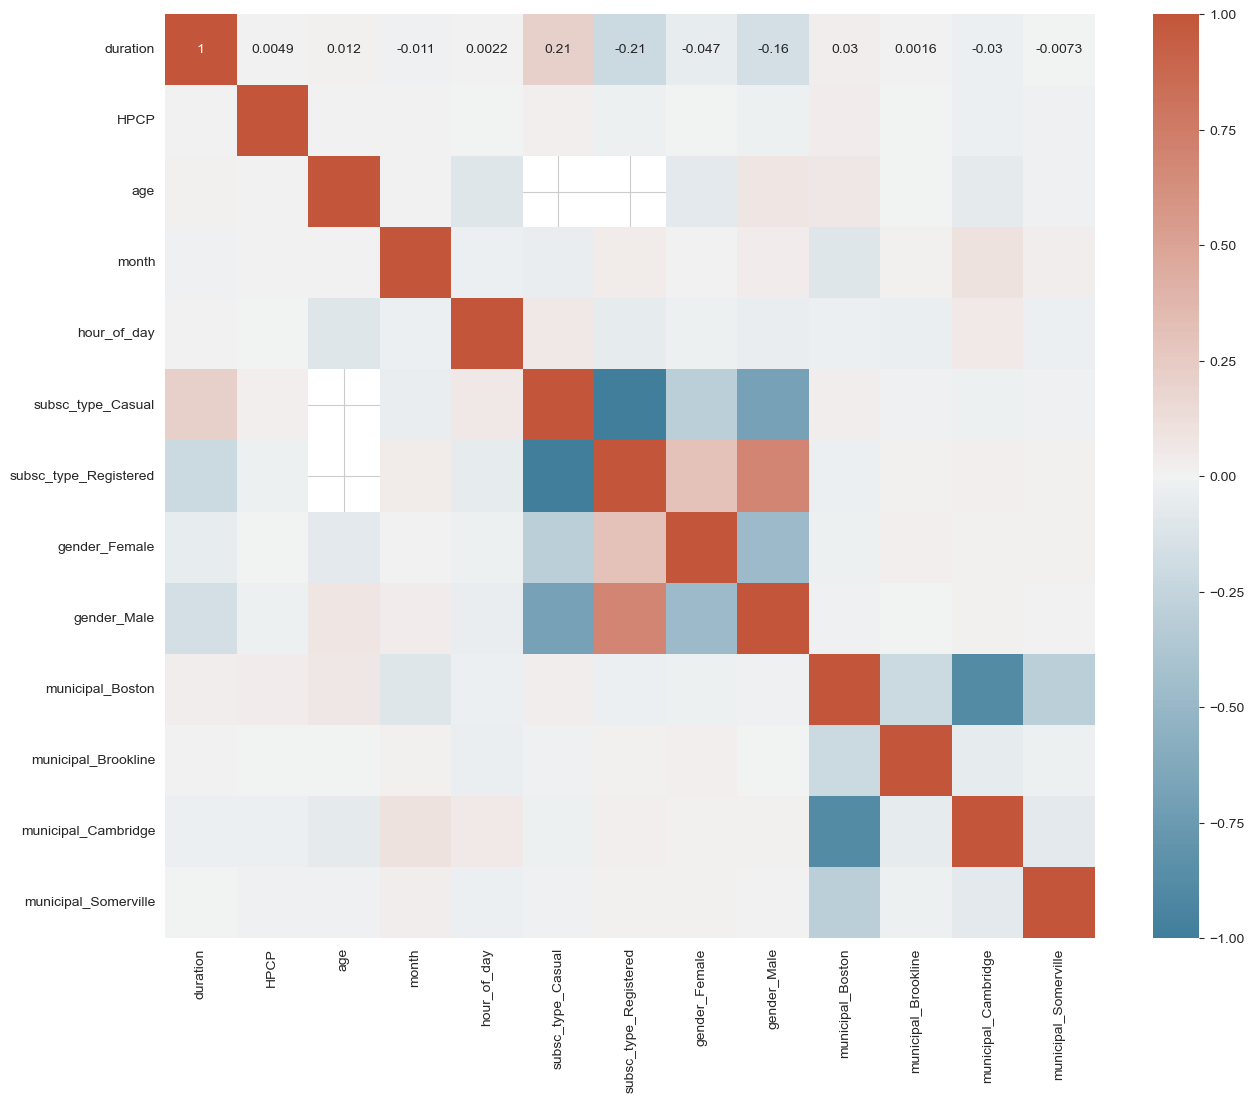

In [64]:
# Plotting a correlation matrix
cor_column = set()

corr = labelled_df.corr(method='pearson')

f, ax = plt.subplots(figsize=(15,12))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True, cmap=cmap)

## Step 3: Prepare Dataset for Training

Here I will drop columns that are too highly correlated & split the data into a test set and a training set, with their corresponding labels

In [57]:
# Making a list of all columns that are too strongly correlated ( > +-75 )
for i in range (len(corr.columns)):
  for j in range (i):
    if abs(corr.iloc[i,j]) > 0.75:
      colname = corr.columns[i]
      cor_column.add(colname)

In [59]:
cor_column

{'municipal_Cambridge', 'subsc_type_Registered'}

In [60]:
df = labelled_df.drop(cor_column, axis=1)

In [61]:
df

,duration,HPCP,age,month,hour_of_day,subsc_type_Casual,gender_Female,gender_Male,municipal_Boston,municipal_Brookline,municipal_Somerville
0,9,0.0,37.0,7,10,0,0,1,1,0,0
1,220,0.0,47.0,7,10,0,0,1,1,0,0
2,56,0.0,70.0,7,10,0,0,1,1,0,0
3,64,0.0,32.0,7,10,0,1,0,1,0,0
4,12,0.0,30.0,7,10,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1579020,720,NaN,NaN,11,23,0,0,1,0,0,0
1579021,480,NaN,NaN,11,23,0,0,1,0,0,0
1579022,540,NaN,NaN,11,23,1,0,0,0,0,0
1579023,120,NaN,NaN,11,23,0,0,1,0,0,0


### Splitting data into test and training set

In [67]:
data = df.values
labels = df['duration'].values

In [68]:
data_train, data_test, labels_train, labels_test = (train_test_split(data, labels,test_size = 0.33,random_state = 10))

In [75]:
# Loading the Model and fitting the data to it
model = HistGradientBoostingRegressor()
model.fit(data_train, labels_train)

HistGradientBoostingRegressor()

In [78]:
train_predictions = model.predict(data_train)
test_predictions = model.predict(data_test)

In [86]:
# Compute and print regression metrics
print("TEST SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_test, test_predictions), 2))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_test, test_predictions), 2))
print("Root Mean Squared Error (RMSE):", round(sm.mean_squared_error(labels_test, test_predictions, squared=False), 2))
print("R-squared:", round(sm.r2_score(labels_test, test_predictions), 2))

# Optional: Residuals
residuals_test = labels_test - test_predictions
print("\nResiduals:", residuals_test)

TEST SET METRICS
Mean Absolute Error (MAE): 74.88
Mean Squared Error (MSE): 1578128.33
Root Mean Squared Error (RMSE): 1256.24
R-squared: 0.77

Residuals: [-11.75522126   1.29668684  -3.2535188  ...  14.06407534 -22.33530445
  -4.92068345]


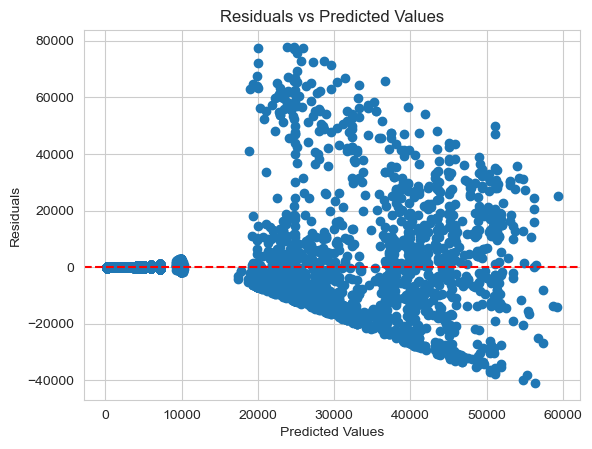

In [88]:
plt.scatter(test_predictions, residuals_test)
plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [87]:
# Compute and print regression metrics
print("TRAINING SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_train, train_predictions), 2))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_train, train_predictions), 2))
print("Root Mean Squared Error (RMSE):", round(sm.mean_squared_error(labels_train, train_predictions, squared=False), 2))
print("R-squared:", round(sm.r2_score(labels_train, train_predictions), 2))

# Optional: Residuals
residuals_train = labels_train - train_predictions
print("\nResiduals:", residuals_train)

TRAINING SET METRICS
Mean Absolute Error (MAE): 74.98
Mean Squared Error (MSE): 1486697.61
Root Mean Squared Error (RMSE): 1219.3
R-squared: 0.78

Residuals: [ 9.62285539  1.29668684 13.06416028 ... -7.56598863 -7.56598863
  1.29668684]


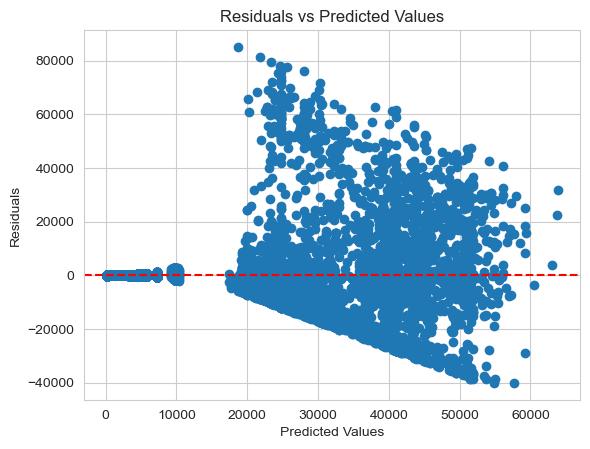

In [90]:
plt.scatter(train_predictions, residuals_train)
plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

In [92]:
model = KNeighborsRegressor()
model.fit(data_train, labels_train)
train_predictions = model.predict(data_train)
test_predictions = model.predict(data_test)

# Compute and print regression metrics
print("TEST SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_test, test_predictions), 2))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_test, test_predictions), 2))
print("Root Mean Squared Error (RMSE):", round(sm.mean_squared_error(labels_test, test_predictions, squared=False), 2))
print("R-squared:", round(sm.r2_score(labels_test, test_predictions), 2))

# Optional: Residuals
residuals_test = labels_test - test_predictions
print("\nResiduals:", residuals_test)
plt.scatter(test_predictions, residuals_test)
plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()
# Compute and print regression metrics
print("TRAINING SET METRICS")
print("====================")
print("Mean Absolute Error (MAE):", round(sm.mean_absolute_error(labels_train, train_predictions), 2))
print("Mean Squared Error (MSE):", round(sm.mean_squared_error(labels_train, train_predictions), 2))
print("Root Mean Squared Error (RMSE):",
      round(sm.mean_squared_error(labels_train, train_predictions, squared=False), 2))
print("R-squared:", round(sm.r2_score(labels_train, train_predictions), 2))

# Optional: Residuals
residuals_train = labels_train - train_predictions
print("\nResiduals:", residuals_train)
plt.scatter(train_predictions, residuals_train)
plt.axhline(y=0, color='r', linestyle='--')  # Add a line at 0 to highlight where residuals should center around
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values